<a href="https://colab.research.google.com/github/bananaEntrepreneur/LoadForecasting/blob/research/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [536]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [537]:
url = "https://raw.githubusercontent.com/bananaEntrepreneur/LoadForecasting/refs/heads/main/data/web_traffic.csv"
df = pd.read_csv(url)

df.head()

,Timestamp,TrafficCount
0,2020-01-20 00:00:00,487.0
1,2020-01-20 00:30:00,385.0
2,2020-01-20 01:30:00,269.0
3,2020-01-20 02:30:00,517.0
4,2020-01-20 03:30:00,129.0


In [538]:
# prepare time series
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp")

daily = df.resample("D", on="Timestamp")["TrafficCount"].sum().reset_index()
daily = daily.rename(columns={"Timestamp":"date","TrafficCount":"traffic"})

In [539]:
# feature engineering
data = daily.copy()

data["lag_1"] = data["traffic"].shift(1)
data["lag_7"] = data["traffic"].shift(7)
data["rolling_7"] = data["traffic"].rolling(7).mean()

data["dayofweek"] = data["date"].dt.dayofweek
data["month"] = data["date"].dt.month

data = data.dropna()

In [540]:
# train model
split = int(len(data)*0.8)

train = data.iloc[:split]
test = data.iloc[split:]

features = ["lag_1","lag_7","rolling_7","dayofweek","month"]

X_train = train[features]
y_train = train["traffic"]

X_test = test[features]
y_test = test["traffic"]

model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))

MAE: 38555.29857336957


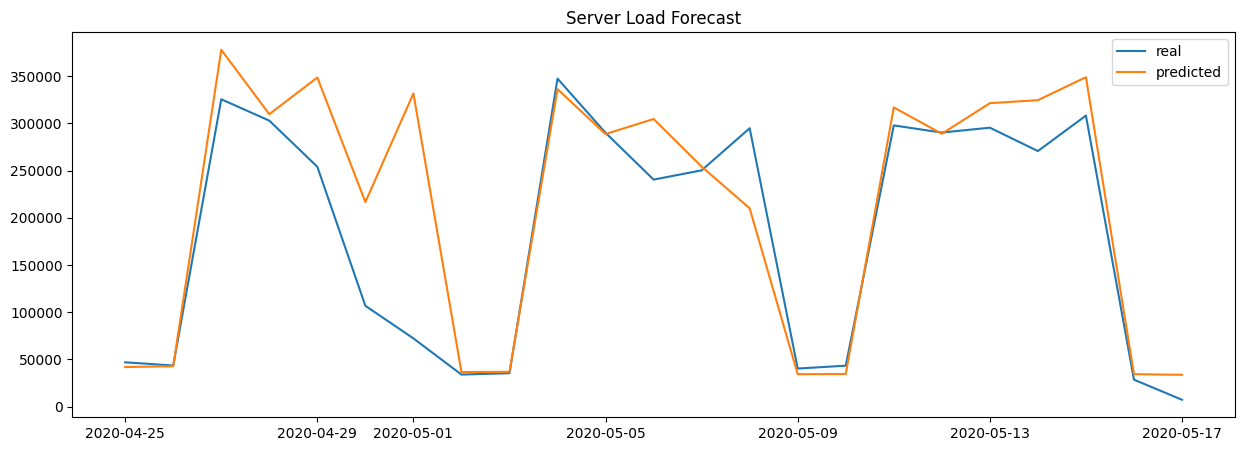

In [541]:
plt.figure(figsize=(15,5))
plt.plot(test["date"], y_test, label="real")
plt.plot(test["date"], preds, label="predicted")
plt.legend()
plt.title("Server Load Forecast")
plt.show()

In [542]:
# capacity planning
RPS_PER_SERVER = 20000
SERVER_COST = 300
SAFETY_BUFFER = 0.30

test = test.copy()
test["predicted_rps"] = preds

test["rps_with_buffer"] = test["predicted_rps"] * (1 + SAFETY_BUFFER)

test["servers_needed"] = np.ceil(test["rps_with_buffer"] / RPS_PER_SERVER)

test["infra_cost"] = test["servers_needed"] * SERVER_COST

print("Max servers:", int(test["servers_needed"].max()))
print("Avg servers:", round(test["servers_needed"].mean(),2))
print("Monthly cost: $", int(test["infra_cost"].mean()))

Max servers: 25
Avg servers: 14.26
Monthly cost: $ 4278


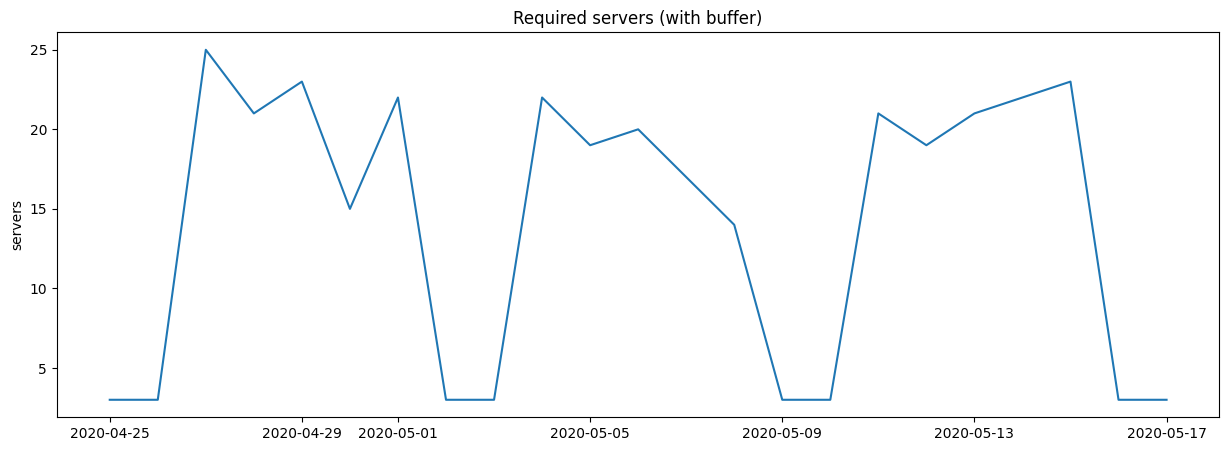

In [543]:
plt.figure(figsize=(15,5))
plt.plot(test["date"], test["servers_needed"])
plt.title("Required servers (with buffer)")
plt.ylabel("servers")
plt.show()

In [544]:
# peak capacity
p95_load = np.percentile(test["rps_with_buffer"], 95)

peak_servers = int(np.ceil(p95_load / RPS_PER_SERVER))
peak_cost = peak_servers * SERVER_COST

print(f"P95 load: {int(p95_load)} RPS")
print(f"Servers for peak: {peak_servers}")
print(f"Peak monthly cost: ${peak_cost}")

P95 load: 453736 RPS
Servers for peak: 23
Peak monthly cost: $6900
